## CAM Heatmap a VGG Visualization

In this notebook we will be using an attention analisys to visualize parts of the image!

This is a pytorch implementation of the paper _Learning Deep Features for Discriminative Localization_ by
_Bolei Zhou, Aditya Khosla, Agata Lapedriza, Aude Oliva and Antonio Torralba_
http://openaccess.thecvf.com/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

ref: https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb

In [ ]:
! wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2024-12-03 13:44:44--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt.4’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2024-12-03 13:44:44 (2.84 MB/s) - ‘imagenet1000_clsidx_to_labels.txt.4’ saved [30564/30564]



In [ ]:
import cv2
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.datasets.cifar as cifar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

import json
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

# Load any cat and dog
def tensor2image(tensor):
    return np.transpose(tensor.numpy(), (1,2,0))
def image2tensor(image):
    image = np.transpose(np.array(image), (2,0,1))
    return torch.from_numpy(np.array(image)).float()
filepath = '/content/golden-retriever-tongue-out.jpg'
testImg = np.array(Image.open(filepath))/256

In [ ]:
# Load model
model = models.vgg16(pretrained=True,)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Text(0.5, 1.0, 'golden retriever')

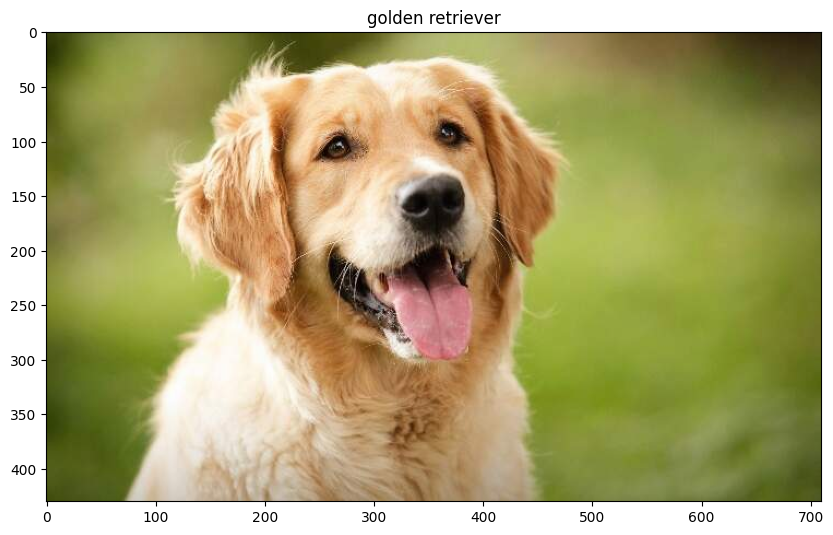

In [ ]:
# Pass tensors for predition
imgTensor = Variable(image2tensor(testImg).unsqueeze_(0), requires_grad=True)
outImg = model(imgTensor)

# Get outputs
values, indices = torch.max(outImg, 1)
test_pred = idx2label[int(indices[0])]

plt.figure(figsize=(10,10))
plt.imshow(testImg)
plt.title(test_pred)

## Ok the network works!

Now we need to calculate the gradients for the class multiply them by the last activation layer..
We need to get the last convolutional layer of the network, wich is located at: features[29]


## Creating a new class based of VGG

We create this class so we can _"chop off"_ a peice of the network, this is required so we can calculate the gradient and get the network state at the last convolution layer[](http://)..

In [ ]:
class CamVGG(nn.Module):
    def __init__(self):
        super(CamVGG, self).__init__()
        self.vgg = models.vgg16(pretrained=True,)
        self.until_last_conv = self.vgg.features[:30]
        # Recreate MaxPool Layer
        self.max_pool = self.vgg.features[30]
        # Get VGG Adaptive Pool
        self.adaptive_pool = self.vgg.avgpool
        # Get VGG Classifier
        self.classifier = self.vgg.classifier
        # Gradients
        self.gradients = None

    def hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.until_last_conv(x)
        h = x.register_hook(self.hook)
        x = self.max_pool(x)
        x = self.adaptive_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x


Let's do a predition to make sure our new class behaves as expected...

In [ ]:
CamModel = CamVGG()
pred = CamModel(imgTensor)
pred_idx = int(pred.argmax(dim=1)[0])
test_pred = idx2label[pred_idx]

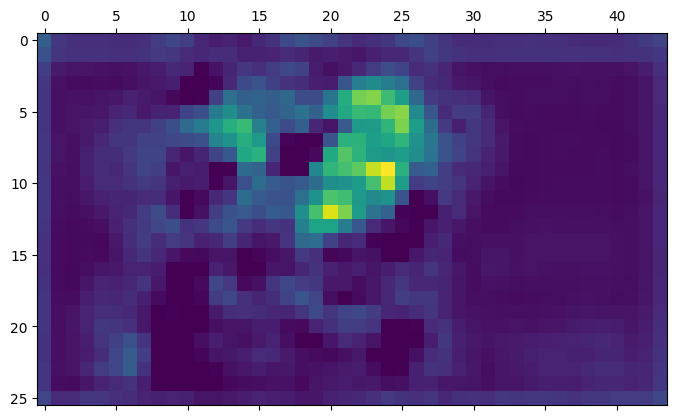

In [ ]:
# Propagate predicted class
pred[:, pred_idx].backward()
# Get the gradient
gradients = CamModel.gradients
# Take the mean on given dimentions...
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
# Multiply calculated gradients by last convolution
activations = CamModel.until_last_conv(imgTensor).detach()
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# Calculate mean for all convolutions to create heatmap
heatmap = torch.mean(activations, dim=1).squeeze()
# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
# Plot Heatmap
plt.matshow(heatmap.squeeze())


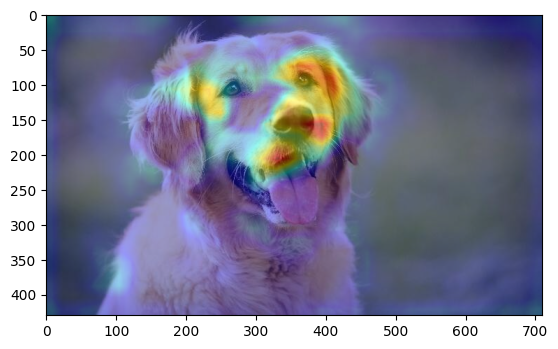

In [ ]:
# Get image as BGR
img = testImg[...,::-1]*255
# Resize Heatmap and apply color map
heatmap1 = np.array(heatmap)
heatmap1 = cv2.resize(heatmap1, (img.shape[1], img.shape[0]))
heatmap1 = np.uint8(255 * heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
# Superpose image
superimposed_img = heatmap1 * 0.4 + img * 0.6
superimposed_img = superimposed_img[...,::-1]

plt.imshow(superimposed_img/255)